In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from Bio import Align

In [203]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')
aligner = Align.PairwiseAligner(
            mode="global",
            scoring="blastp"
        )
rules = pd.read_csv(
            filepath_or_buffer=Path(filepaths.artifacts) / 'minimal1224_all_uniprot.tsv',
            sep='\t'
        )
rules.set_index('Name', inplace=True)

In [28]:
dataset = 'sprhea'
toc = 'v3_folded_n_10000'
strategy = 'homology'


reactions = load_json(Path(filepaths.data) / dataset / (toc + ".json"))
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / (toc + ".csv")
    )

reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

# toc = pd.read_csv(Path(filepaths.data) / dataset / f"{toc}.csv", sep='\t')
# pid2seq = {row['Entry']: row['Sequence'] for i, row in toc.iterrows()}

split_dir = Path(filepaths.scratch) / f"{dataset}_{toc}/{strategy}/3fold"

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(split_dir / f"train_val_{i}.parquet")
    )
test = pd.read_parquet(split_dir / 'test.parquet')

Constructing v3_folded_n_10000 sparse adjacency matrix


In [14]:
if strategy == 'rcmcs':
    S = np.load(
        Path(filepaths.results) / 'similarity_matrices' / f"{dataset}_{toc}_{strategy}.npy"
    )
elif strategy == 'homology':
    S = np.load(
        Path(filepaths.results) / 'similarity_matrices' / f"{dataset}_{toc}_gsi.npy"
    )

S = S.astype(np.float16)

In [21]:
S[0, 0]

1.0

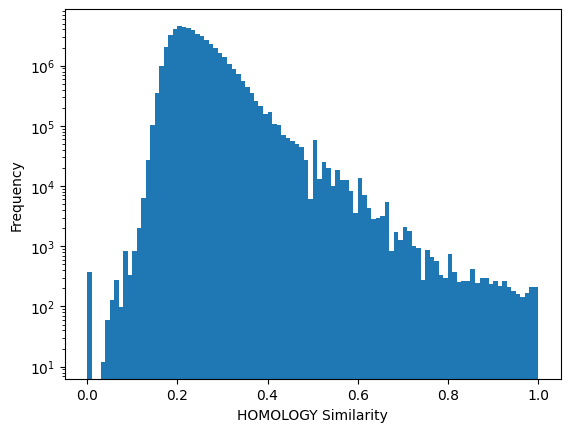

In [163]:
sims = S[np.triu_indices_from(S, k=1)]
plt.hist(sims, bins=100)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel(f"{strategy.upper()} Similarity")
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_similarity_hist.svg", format='svg')
plt.show()

In [16]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,1021,1224,Q642M9,5268,"[0.023809277, 0.33661747, 0.08051007, 0.039295...",Oc1ccccc1O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O...,"[[[1, 2, 3, 4, 5, 6], [3, 4, 5, 45, 46, 47]], ...",1
1,1021,1225,Q642M9,4732,"[0.023809277, 0.33661747, 0.08051007, 0.039295...",OC1COC(O)C(O)C1O.NC(=O)c1ccc[n+](C2OC(COP(=O)(...,"[[[4, 5], [3, 4, 5, 6, 7, 47]], [[3, 4, 5, 45,...",1
2,9757,1259,P43284,110,"[0.037144076, 0.2443147, 0.20602834, -0.105538...",O=P(O)(O)OCC(O)C(O)c1c[nH]c2ccccc12.NC(CO)C(=O...,"[[[10, 8, 9], [2, 3]], [[2, 3], [1, 0], [0]]]",1
3,2703,2361,P75919,6832,"[0.026481781, -0.032907866, -0.042464588, 0.15...",NCCO.*C(=O)OCC(COP(=O)(O)OCC(O)COP(=O)(O)OCC(C...,"[[[3], [11, 8]], [[16], [11, 8]]]",1
4,8503,1406,J7LP58,2704,"[-0.17998445, 0.14802393, 0.09429812, -0.01905...",CC(C)=CCCC(C)=CCCC(C)=CCOP(=O)(O)OP(=O)(O)O>>C...,"[[[1, 3, 8, 9, 10, 11, 13, 14, 15]], [[10, 9, ...",1


[0.6924 0.609  0.6494 ... 0.615  0.855  0.5864]


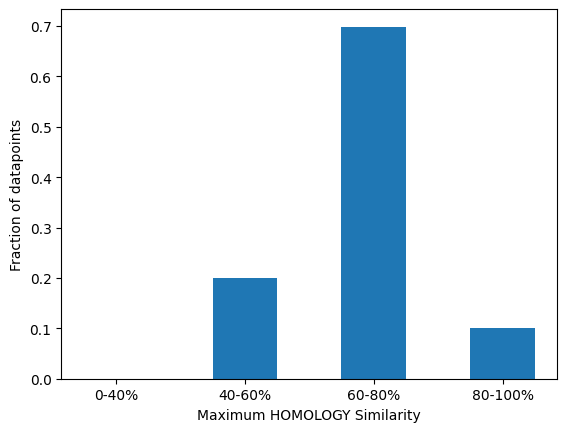

[0.7334 0.65   0.625  ... 0.6924 0.6    0.7144]


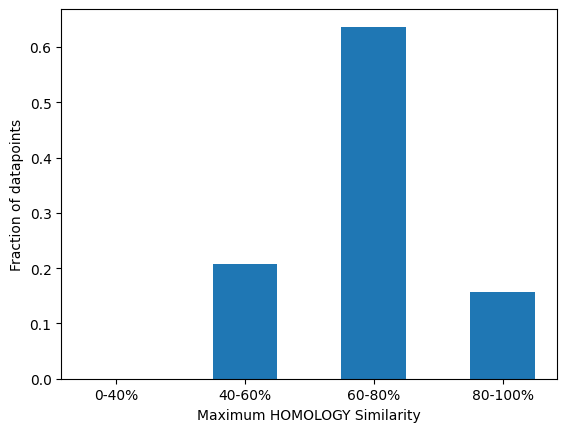

[0.681  0.6465 0.9473 ... 0.722  0.9805 0.6875]


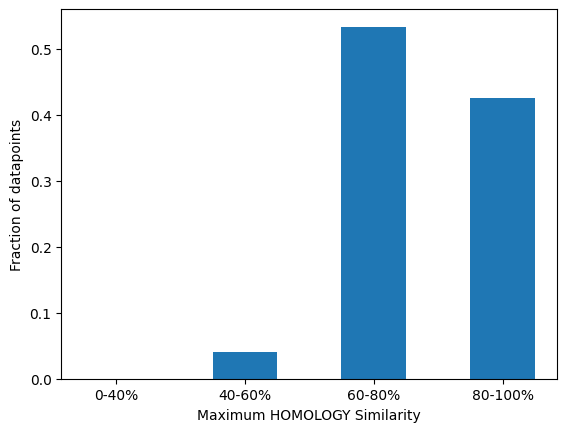

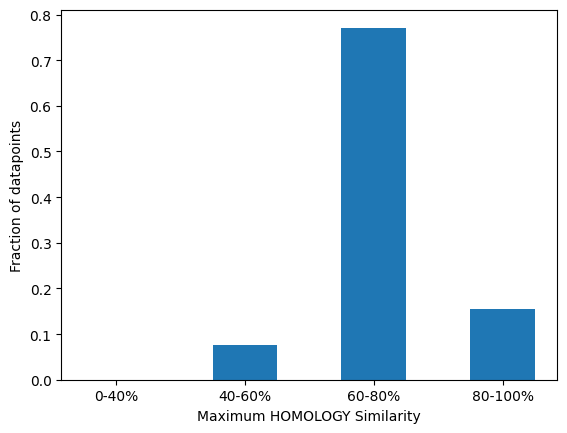

In [24]:
if strategy == 'rcmcs':
    key = 'reaction_idx'
elif strategy == 'homology':
    key = 'protein_idx'

thresholds = [1.0, 0.8, 0.6, 0.4]
thresholds = sorted(thresholds)
xticklabels = [f"0-{thresholds[0]*100:.0f}%"] + [f"{thresholds[j]*100:.0f}-{thresholds[j+1]*100:.0f}%" for j in range(len(thresholds) - 1)]

for i, val in enumerate(train_val):
    val_idx = list(set(val[key]))
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_idx = list(set(train[key]))
    max_sims = S[:, val_idx][train_idx].max(axis=0)
    cdf = []
    for j, th in enumerate(thresholds):
        if j == 0:
            in_range = len(np.argwhere(max_sims <= th))
        else:
            less_than_th = len(np.argwhere(max_sims <= th))
            less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
            in_range = less_than_th - less_than_prev
        
        cdf.append(in_range / len(max_sims))

    plt.bar(thresholds, cdf, width=0.1)
    plt.xticks(thresholds, xticklabels)
    plt.ylabel('Fraction of datapoints')
    plt.xlabel(f"Maximum {strategy.upper()} Similarity")
    plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_train_val_{i}_similarity_bar_chart.svg", format='svg')
    plt.show()

val_idx = list(set(test[key]))
train = pd.concat(train_val)
train_idx = list(set(train[key]))
max_sims = S[:, val_idx][train_idx].max(axis=0)
cdf = []
for j, th in enumerate(thresholds):
    if j == 0:
        in_range = len(np.argwhere(max_sims <= th))
    else:
        less_than_th = len(np.argwhere(max_sims <= th))
        less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
        in_range = less_than_th - less_than_prev
    
    cdf.append(in_range / len(max_sims))

plt.bar(thresholds, cdf, width=0.1)
plt.xticks(thresholds, xticklabels)
plt.xlabel(f"Maximum {strategy.upper()} Similarity")
plt.ylabel('Fraction of datapoints')
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_test_similarity_bar_chart.svg", format='svg')
plt.show()

In [18]:
cdf

[0.0, 0.075046904315197, 0.7711069418386491, 0.15384615384615385]

In [19]:
for i, elt in enumerate(train_val):
    print(f"Fold {i}")
    print("+", len(elt[elt['y'] == 1]) / len(elt))
    print("-", len(elt[elt['y'] == 0]) / len(elt))

print(f"Test")
print("+", len(test[test['y'] == 1]) / len(test))
print("-", len(test[test['y'] == 0]) / len(test))

Fold 0
+ 0.10014734251818996
- 0.89985265748181
Fold 1
+ 0.09991980447567403
- 0.9000801955243259
Fold 2
+ 0.09910915966599833
- 0.9008908403340017
Test
+ 0.4818181818181818
- 0.5181818181818182


In [50]:
from src.cross_validation import parse_cd_hit_clusters
from collections import defaultdict
from itertools import chain
cluster_dir = Path(filepaths.artifacts) / 'clustering'

In [164]:
cluster_path = cluster_dir / f"{dataset}_{toc}_{strategy}_{60}.clstr"
clusters = parse_cd_hit_clusters(cluster_path)
point_to_cluster = {id: cid for cid, ids in clusters.items() for id in ids}

In [165]:
sample_idx = {v: k for k, v in idx_sample.items()}

In [176]:
all_ids = set(chain(*clusters.values()))
for cluster, ids in clusters.items():
    in_idxs = [sample_idx[id] for id in ids]
    out_ids = list(all_ids - set(ids))
    out_idxs = [sample_idx[id] for id in out_ids]
    max_sims = S[:, in_idxs][out_idxs].max(axis=0)
    argmax_sims = [out_idxs[idx] for idx in S[:, in_idxs][out_idxs].argmax(axis=0)]
    print(f"Cluster: {cluster}. {max_sims}")

    if cluster == 2:
        break

Cluster: 0. [0.952]
Cluster: 1. [0.9]
Cluster: 2. [0.933]


In [192]:
test_in = in_idxs[0]
S[out_idxs, test_in].argmax()

2922

In [197]:
out_idxs[2922]

738

In [198]:
idx_sample[738]

'P19985'

In [200]:
idx_sample[test_in]

'Q5VST9'

In [202]:
S[738, test_in]

0.933

In [177]:
top_match_ids = [idx_sample[idx] for idx in argmax_sims]

In [178]:
top_match_ids, ids

(['P19985'], ['Q5VST9'])

In [179]:
_toc = pd.read_csv(Path(filepaths.data) / dataset / f"{toc}.csv", sep='\t')
pid2seq = {row['Entry']: row['Sequence'] for i, row in _toc.iterrows()}
seq1 = pid2seq[ids[0]]
seq2 = pid2seq[top_match_ids[0]]
print(seq1)
print(seq2)

MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKDQQPVAAGARFRLAQDGDLYRLTILDLALGDSGQYVCRARNAIGEAFAAVGLQVDAEAACAEQAPHFLLRPTSIRVREGSEATFRCRVGGSPRPAVSWSKDGRRLGEPDGPRVRVEELGEASALRIRAARPRDGGTYEVRAENPLGAASAAAALVVDSDAADTASRPGTSTAALLAHLQRRREAMRAEGAPASPPSTGTRTCTVTEGKHARLSCYVTGEPKPETVWKKDGQLVTEGRRHVVYEDAQENFVLKILFCKQSDRGLYTCTASNLVGQTYSSVLVVVREPAVPFKKRLQDLEVREKESATFLCEVPQPSTEAAWFKEETRLWASAKYGIEEEGTERRLTVRNVSADDDAVYICETPEGSRTVAELAVQGNLLRKLPRKTAVRVGDTAMFCVELAVPVGPVHWLRNQEEVVAGGRVAISAEGTRHTLTISQCCLEDVGQVAFMAGDCQTSTQFCVSAPRKPPLQPPVDPVVKARMESSVILSWSPPPHGERPVTIDGYLVEKKKLGTYTWIRCHEAEWVATPELTVADVAEEGNFQFRVSALNSFGQSPYLEFPGTVHLAPKLAVRTPLKAVQAVEGGEVTFSVDLTVASAGEWFLDGQALKASSVYEIHCDRTRHTLTIREVPASLHGAQLKFVANGIESSIRMEVRAAPGLTANKPPAAAAREVLARLHEEAQLLAELSDQAAAVTWLKDGRTLSPGPKYEVQASAGRRVLLVRDVARDDAGLYECVSRGGRIAYQLSVQGLARFLHKDMAGSCVDAVAGGPAQFECETSEAHVHVHWYKDGMELGHSGERFLQEDVGTRHRLVAATVTRQDEGTYSCRVGEDSVDFRLRVSEPKVVFAKEQLARRKLQAEAGASATLSCEVAQAQTEVTWYKDGKKLSSSSKVCMEATGCTRRLVVQQAGQADAGEYSCEAGGQRLSFHLDVKEPKVVFAKDQVAHSEVQAEAGASA

In [181]:
S[in_idxs[0], argmax_sims[0]]

0.933

In [228]:
def global_sequence_identity(seq1:str, seq2:str, aligner:Align.PairwiseAligner):
    '''
    Aligns two sequences and calculates global sequence
    identity = # aligned residues / min(len(seq1), len(seq2))

    Args
    ------
    seq:str
        Amino acid sequence
    aligner:Bio.Align.PairwiseAligner
        Pairwise aligner object
    '''
    alignment = aligner.align(seq1, seq2)[0]
    t_segments, q_segments = alignment.aligned

    talign = ''
    qalign = ''
    for i in range(t_segments.shape[0]):
        talign += alignment.target[t_segments[i, 0] : t_segments[i, 1]]
        qalign += alignment.query[q_segments[i, 0] : q_segments[i, 1]]

    ct = 0
    for t, q in zip(talign, qalign):
        if t == q:
            ct += 1
    
    return ct / min(len(alignment.target), len(alignment.query))

In [237]:
aligner = Align.PairwiseAligner(
            mode="global",
            scoring="blastp",
        )
aligner.open_gap_score = -6
aligner.extend_gap_score = -1
aligner.mismatch_score = -2

global_sequence_identity(seq1, seq2, aligner)

0.9333333333333333

In [227]:
print(alignment[0])

target            0 MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKDQQPVAAGARFRLAQ
                  0 ------------------------------------------------------------
query             0 ------------------------------------------------------------

target           60 DGDLYRLTILDLALGDSGQYVCRARNAIGEAFAAVGLQVDAEAACAEQAPHFLLRPTSIR
                 60 ------------------------------------------------------------
query             0 ------------------------------------------------------------

target          120 VREGSEATFRCRVGGSPRPAVSWSKDGRRLGEPDGPRVRVEELGEASALRIRAARPRDGG
                120 -------------------------------------------------||---------
query             0 -------------------------------------------------RI---------

target          180 TYEVRAENPLGAASAAAALVVDSDAADTASRPGTSTAALLAHLQRRREAMRAEGAPASPP
                180 ------------------------------------------------------------
query             2 ------------------------------------------------------------

target          240 STGT

In [219]:
alignment = aligner.align(seq1, seq2)
print(alignment)

In [174]:
tab_contents = pd.read_csv(Path(filepaths.data) / dataset / f"{toc}.csv", sep='\t')
pid2seq = {row['Entry']: row['Sequence'] for i, row in tab_contents.iterrows()}
sim_i_to_id = {i : id for i, id in enumerate(pid2seq.keys())}
tab_contents.head()

,Entry,Label,Sequence
0,Q12003,210;85,MISIVLELFQNLCCCRGFSDATIRVNDKRYRIQRLLGEGGMSFVYL...
1,O46516,1328;2982,MAGWSCLVTGAGGFLGQRIVRLLVEEKEVQEIRALDKVFRPELREE...
2,P36897,210;85,MEAAVAAPRPRLLLLVLAAAAAAAAALLPGATALQCFCHLCTKDNF...
3,Q9N0F1,549,MLSRSRCVSRAFSRSLSAFQKGNCPLGRRSLPGISLCQGPGYPDSR...
4,A7MCT6,2609,MAVPPSAPVPCSPFYLRRQEPCPQCSWSMEEKAVASAGCWEPPGPP...


In [175]:
for k in sim_i_to_id.keys():
    print(sim_i_to_id[k], idx_sample[k])

Q12003 Q12003
O46516 O46516
P36897 P36897
Q9N0F1 Q9N0F1
A7MCT6 A7MCT6
Q5ZX22 Q5ZX22
P54756 P54756
Q88CC1 Q88CC1
Q9SZ92 Q9SZ92
Q9SA22 Q9SA22
Q9JL56 Q9JL56
Q00497 Q00497
P51696 P51696
Q7XT07 Q7XT07
F2XF95 F2XF95
Q63475 Q63475
P81693 P81693
Q5ZKH6 Q5ZKH6
P0AEI6 P0AEI6
Q8BK84 Q8BK84
Q9F5K6 Q9F5K6
Q9LUM0 Q9LUM0
Q8BVU5 Q8BVU5
Q61694 Q61694
Q8WUD6 Q8WUD6
Q6DG88 Q6DG88
B7UI22 B7UI22
P07764 P07764
Q9H1R3 Q9H1R3
O33363 O33363
Q9NP81 Q9NP81
P20605 P20605
Q29593 Q29593
Q8HXX5 Q8HXX5
Q9T0J1 Q9T0J1
Q3ZU95 Q3ZU95
Q05652 Q05652
Q5R814 Q5R814
Q86UL3 Q86UL3
B9JN19 B9JN19
Q6CZ25 Q6CZ25
G0HQ35 G0HQ35
A0JN95 A0JN95
Q9M6K1 Q9M6K1
Q9SJI9 Q9SJI9
Q96DP5 Q96DP5
H2KZU7 H2KZU7
Q27746 Q27746
Q3T1J2 Q3T1J2
P25306 P25306
P97756 P97756
P14561 P14561
P32669 P32669
Q6DE73 Q6DE73
P09368 P09368
A3KGF7 A3KGF7
Q9MAT5 Q9MAT5
A0A7G5KLV0 A0A7G5KLV0
Q9SLE0 Q9SLE0
Q9LSZ9 Q9LSZ9
O75063 O75063
Q08156 Q08156
C0JAY8 C0JAY8
Q0P8J7 Q0P8J7
P15693 P15693
P0A6L0 P0A6L0
Q9ES38 Q9ES38
O06319 O06319
Q3MSM4 Q3MSM4
B5RAG0 B5RAG0
P0AB77 P0AB7